In [416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
%matplotlib inline

In [417]:
sns.set_style("ticks")
sns.set_palette('deep')

In [418]:
data = pd.read_csv('CAX_MortgageModeling_Train.csv')
dfx = pd.DataFrame(data)

In [419]:
# Check Shape
dfx.shape

(45642, 22)

In [420]:
#Checking Imbalances
Counter(dfx['RESULT'])

Counter({'FUNDED': 36023, 'NOT FUNDED': 9619})

In [421]:
#Checking for Zeros
dfx.isin([0]).any()

Unique_ID            False
MORTGAGE NUMBER      False
PROPERTY VALUE       False
MORTGAGE PAYMENT     False
GDS                   True
LTV                  False
TDS                   True
AMORTIZATION         False
MORTGAGE AMOUNT      False
RATE                 False
MORTGAGE PURPOSE     False
PAYMENT FREQUENCY    False
PROPERTY TYPE        False
TERM                 False
FSA                  False
AGE RANGE            False
GENDER               False
INCOME               False
INCOME TYPE          False
NAICS CODE           False
CREDIT SCORE          True
RESULT               False
dtype: bool

In [422]:
#Zero Counts
dfx[dfx[['GDS', 'TDS', 'CREDIT SCORE']] <= 0].count()

Unique_ID               0
MORTGAGE NUMBER         0
PROPERTY VALUE          0
MORTGAGE PAYMENT        0
GDS                   428
LTV                     0
TDS                    80
AMORTIZATION            0
MORTGAGE AMOUNT         0
RATE                    0
MORTGAGE PURPOSE        0
PAYMENT FREQUENCY       0
PROPERTY TYPE           0
TERM                    0
FSA                     0
AGE RANGE               0
GENDER                  0
INCOME                  0
INCOME TYPE             0
NAICS CODE              0
CREDIT SCORE         1176
RESULT                  0
dtype: int64

In [423]:
# Encode Target Variable
def encode_target(df):
    
    df['RESULT'] = df['RESULT'].replace({'NOT FUNDED': 0, 'FUNDED': 1})

    return df

dfx = encode_target(dfx)

In [424]:
dfx.head()

,Unique_ID,MORTGAGE NUMBER,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,...,PROPERTY TYPE,TERM,FSA,AGE RANGE,GENDER,INCOME,INCOME TYPE,NAICS CODE,CREDIT SCORE,RESULT
0,CAX_Train_1,1,900000,5429,61.98,65.00,71.63,360,1040000.0,4.0,...,Single Detached,12,L4C,Under 25,Male,108000,8,44-45,681,1
1,CAX_Train_2,2,386000,2179,35.22,74.29,40.65,360,390000.0,4.5,...,Single Detached,12,L9T,70 and over,Male,78000,2,56,710,1
2,CAX_Train_3,3,531000,2152,30.97,80.00,35.41,360,424800.0,3.5,...,Single Detached,6,M1N,35-39,Female,87000,2,72,709,1
3,CAX_Train_4,4,1200000,5410,19.04,75.00,34.14,360,960000.0,5.5,...,Single Detached,12,M2M,45-49,Male,300000,8,54,761,1
4,CAX_Train_5,5,350000,3342,29.59,80.00,34.85,360,592000.0,5.0,...,Single Detached,12,L7G,50-54,Male,147000,8,62,762,1


In [425]:
# Cleaning Function
def clean_data(df):
    
    # Set Index
    df = df.set_index('Unique_ID')
    
    # Drop Mortgage Number
    df = df.drop(['MORTGAGE NUMBER'], axis=1)
    
    # Add Property Value
    df['PROPERTY_VAL_DELTA'] = df['PROPERTY VALUE'] - (df['MORTGAGE AMOUNT'] / (df['LTV'] / 100))
    
    # Update Property Value per Competition
    df['PROPERTY VALUE'] = df['MORTGAGE AMOUNT'] / (df['LTV'] / 100)
    
    # Set Negative GDS Values to Zero, per Competition
    df['GDS'] = np.where(df['GDS'] < 0, 0, df['GDS'])
    
    # Split FSA & Encode Urban or Rural
    df_temp = df['FSA'].str.split('', n=3, expand=True)
    df_temp[2] = df_temp[2].astype(int)
    df_temp['URBAN'] = np.where(df_temp[2] > 0, 1, 0)
    df_temp.drop([0, 2, 3], axis=1, inplace=True)
    
    # Name Territory Column, drop old FSA column
    df_temp.rename(columns={1: 'TERRITORY'}, inplace=True)
    df = pd.concat([df, df_temp], axis=1)
    df = df.drop(['FSA'], axis=1)
    
    return df

df = clean_data(dfx)

In [426]:
# Drop Mortgage Amount & Property Value outliers
z_thresh = 5

def remove_outliers(df):
    
    df['mortgage_amt_z'] = zscore(df['MORTGAGE AMOUNT'])
    df['property_val_z'] = zscore(df['PROPERTY VALUE'])
    
    df = df[(df['property_val_z'] <= z_thresh) & (df['mortgage_amt_z'] <= z_thresh)]
    df = df.drop(['mortgage_amt_z', 'property_val_z'], axis=1)
    
    df = df[(df['RATE'] < 9) & (df['RATE'] > 2.5)]
    
    df = df[(df['LTV'] < 200)]
    
    df = df[(df['TDS'] < 100)]
    
    return df

df = remove_outliers(df)
df['RESULT'].value_counts()
print(f'Total Observations: {len(df)}')

1    35533
0     9411
Name: RESULT, dtype: int64

Total Observations: 44944


In [427]:
# Some Credit Scores are Zero
df[df['CREDIT SCORE'] == 0].groupby('RESULT')['CREDIT SCORE'].count()

RESULT
0    306
1    848
Name: CREDIT SCORE, dtype: int64

In [428]:
# Check degree of Imbalance after Cleaning
df['RESULT'].value_counts(normalize=True)

1    0.790606
0    0.209394
Name: RESULT, dtype: float64

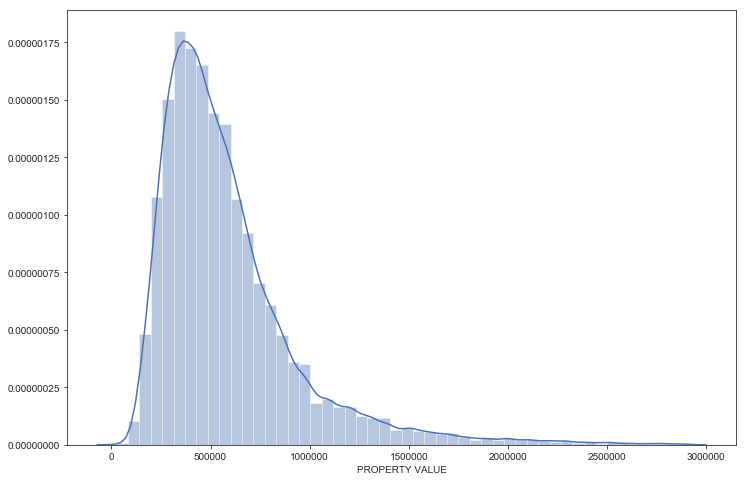

In [429]:
# Histogram of Property Value
plt.figure(figsize=(12,8))
sns.distplot(df['PROPERTY VALUE']);

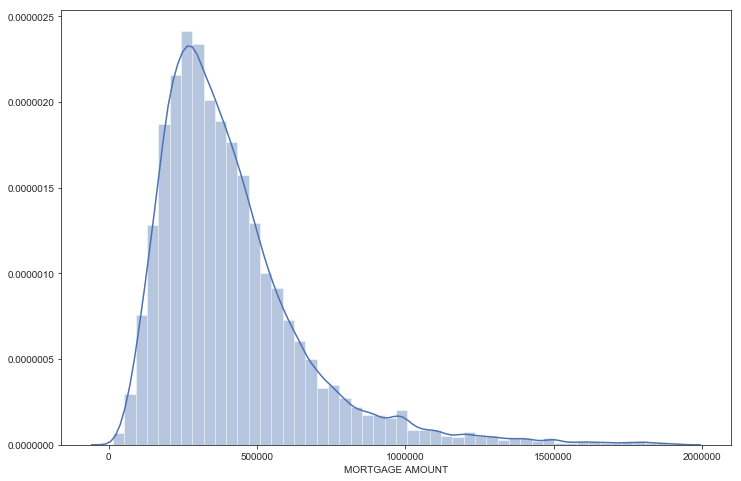

In [430]:
# Histogram of Property Value
plt.figure(figsize=(12,8))
sns.distplot(df['MORTGAGE AMOUNT']);

## EDA

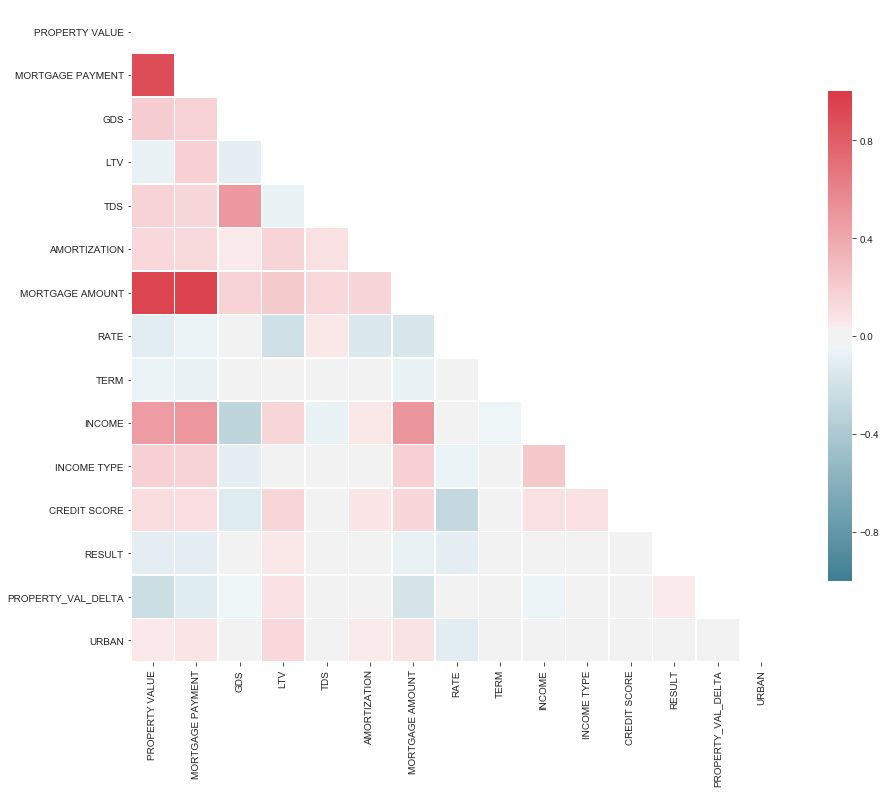

In [431]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [432]:
df.describe()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,RESULT,PROPERTY_VAL_DELTA,URBAN
count,4.494400e+04,44944.000000,44944.000000,44944.000000,44944.000000,44944.000000,4.494400e+04,44944.000000,44944.000000,4.494400e+04,44944.000000,44944.000000,44944.000000,4.494400e+04,44944.000000
mean,5.877610e+05,2321.107667,27.284940,70.808260,37.471282,355.327519,4.131549e+05,4.639724,15.313724,1.229564e+05,5.299595,662.461886,0.790606,-2.475734e+04,0.953097
std,3.592544e+05,1382.745216,12.649606,11.415061,9.574744,17.925459,2.506017e+05,0.616756,7.461221,1.048075e+05,3.272462,132.589476,0.406881,1.286460e+05,0.211433
min,2.612277e+04,141.000000,0.000000,6.667000,-10.700000,60.000000,1.500000e+04,2.750000,6.000000,2.000000e+03,-1.000000,0.000000,0.000000,-2.135000e+06,0.000000
25%,3.500008e+05,1404.000000,19.730000,65.000000,32.770000,360.000000,2.456030e+05,4.250000,12.000000,6.900000e+04,2.000000,623.000000,1.000000,-1.678282e+04,1.000000
50%,5.000000e+05,2024.000000,29.070000,75.000000,38.210000,360.000000,3.560000e+05,4.500000,12.000000,9.700000e+04,6.000000,676.000000,1.000000,0.000000e+00,1.000000
75%,7.050000e+05,2842.000000,35.710000,80.000000,42.040000,360.000000,5.080000e+05,5.000000,12.000000,1.450000e+05,8.000000,735.000000,1.000000,7.358352e+00,1.000000
max,2.900232e+06,24451.000000,99.410000,95.000000,99.960000,480.000000,1.921875e+06,8.500000,60.000000,3.430000e+06,20.000000,899.000000,1.000000,8.775000e+06,1.000000


In [433]:
df.corr()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,RESULT,PROPERTY_VAL_DELTA,URBAN
PROPERTY VALUE,1.000000,0.897522,0.196305,-0.073849,0.166403,0.133368,0.939118,-0.115551,-0.062121,0.461765,0.181628,0.109924,-0.096215,-0.228919,0.051967
MORTGAGE PAYMENT,0.897522,1.000000,0.176933,0.183656,0.146080,0.125134,0.949100,-0.059151,-0.077869,0.494280,0.177277,0.108189,-0.092577,-0.120502,0.070816
GDS,0.196305,0.176933,1.000000,-0.086277,0.486347,0.044430,0.170480,0.020976,-0.005514,-0.297181,-0.088920,-0.122654,-0.023496,-0.046616,0.003909
LTV,-0.073849,0.183656,-0.086277,1.000000,-0.066904,0.162991,0.217376,-0.208369,-0.026247,0.149571,-0.004794,0.153033,0.061720,0.086920,0.134132
TDS,0.166403,0.146080,0.486347,-0.066904,1.000000,0.093781,0.136152,0.061499,-0.028092,-0.067293,0.024191,0.023084,-0.036637,-0.036685,-0.005300
AMORTIZATION,0.133368,0.125134,0.044430,0.162991,0.093781,1.000000,0.163731,-0.143061,-0.035635,0.059065,0.028894,0.069803,0.013567,-0.021505,0.044679
MORTGAGE AMOUNT,0.939118,0.949100,0.170480,0.217376,0.136152,0.163731,1.000000,-0.164678,-0.070164,0.503886,0.180870,0.142305,-0.071800,-0.175579,0.082210
RATE,-0.115551,-0.059151,0.020976,-0.208369,0.061499,-0.143061,-0.164678,1.000000,0.002002,-0.036653,-0.061569,-0.276649,-0.087430,-0.003383,-0.114272
TERM,-0.062121,-0.077869,-0.005514,-0.026247,-0.028092,-0.035635,-0.070164,0.002002,1.000000,-0.045286,0.013294,-0.008976,0.016648,-0.009664,-0.021561
INCOME,0.461765,0.494280,-0.297181,0.149571,-0.067293,0.059065,0.503886,-0.036653,-0.045286,1.000000,0.221272,0.098293,-0.012550,-0.051914,0.026420


In [434]:
#sns.pairplot(df);

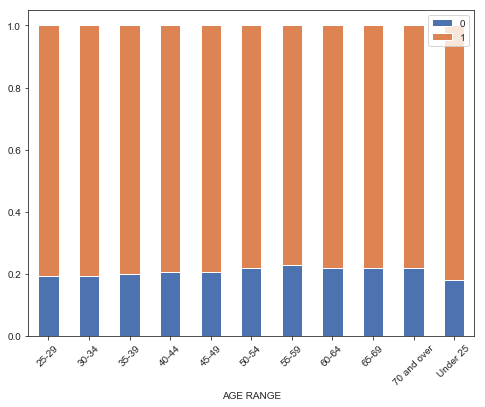

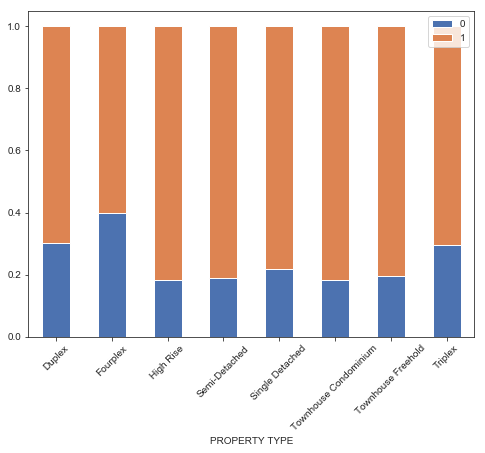

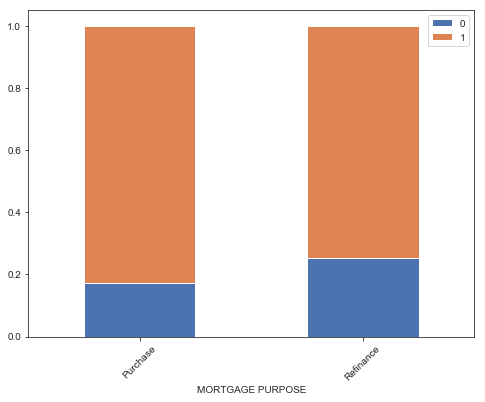

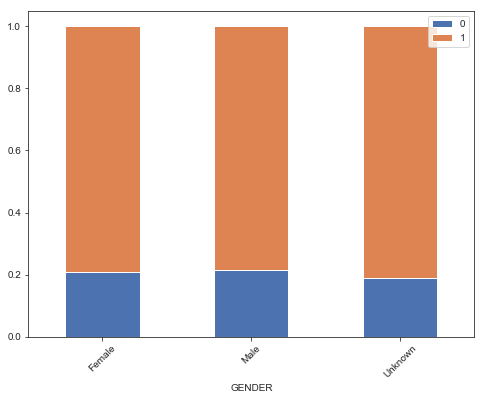

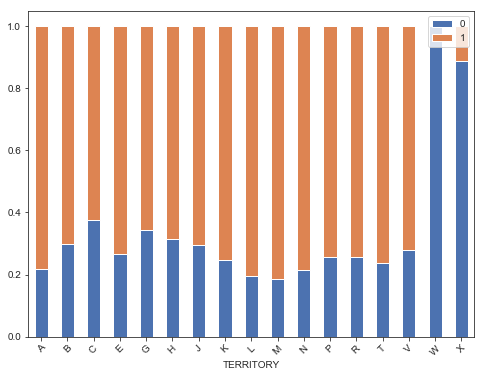

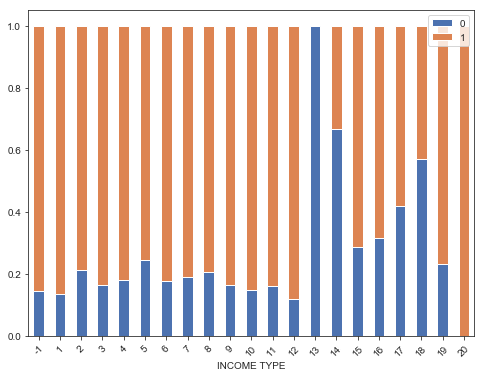

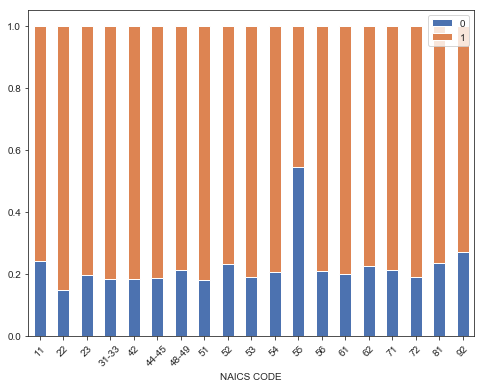

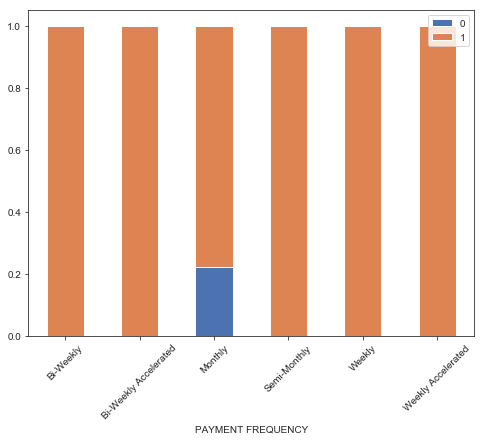

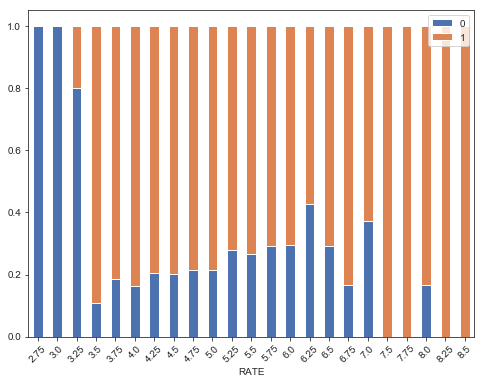

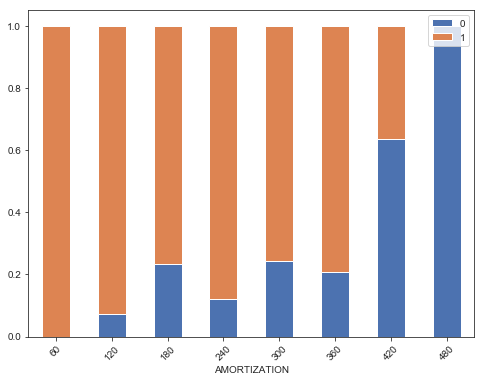

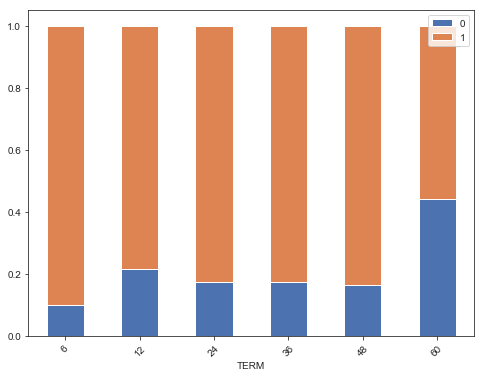

In [435]:
def stacked_bar_plot(col_1, col_2):
    
    x = df.groupby(col_1)[col_2].value_counts(normalize=True).unstack()
    x.plot(kind='bar', stacked='True', figsize=(8,6))
    plt.legend(loc=1)
    plt.xticks(rotation=45)
    plt.show();

    
stack_list = ['AGE RANGE', 'PROPERTY TYPE', 'MORTGAGE PURPOSE', 'GENDER', 'TERRITORY', \
                'INCOME TYPE', 'NAICS CODE', 'PAYMENT FREQUENCY', 'RATE', 'AMORTIZATION', 'TERM']

for feature in stack_list:
    
    stacked_bar_plot(feature, 'RESULT')


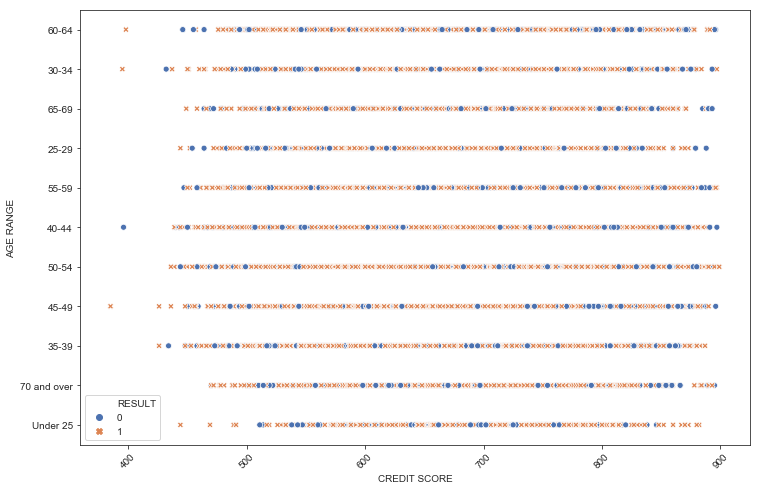

In [436]:
def scatter_plot(col_1, col_2, col_hue, data):
    
    plt.figure(figsize=(12,8))
    sns.scatterplot(x=col_1, y=col_2, hue=col_hue, data=data, style=col_hue)
    plt.xticks(rotation=45)
    plt.show();

scatter_plot('CREDIT SCORE', 'AGE RANGE', 'RESULT', df[df['CREDIT SCORE'] > 0])

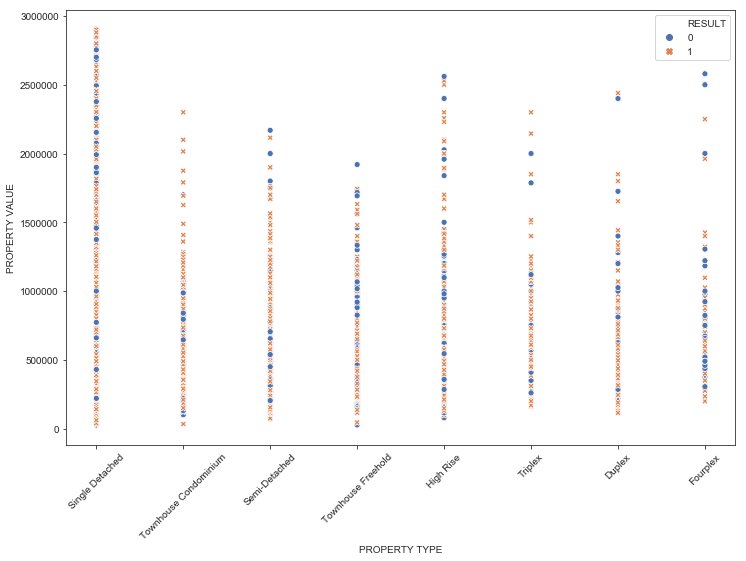

In [437]:
scatter_plot('PROPERTY TYPE', 'PROPERTY VALUE', 'RESULT', df)

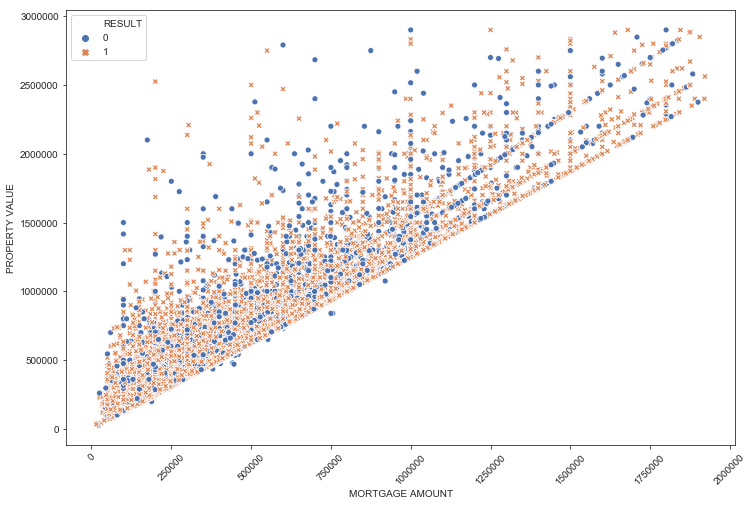

In [438]:
scatter_plot('MORTGAGE AMOUNT', 'PROPERTY VALUE', 'RESULT', df)

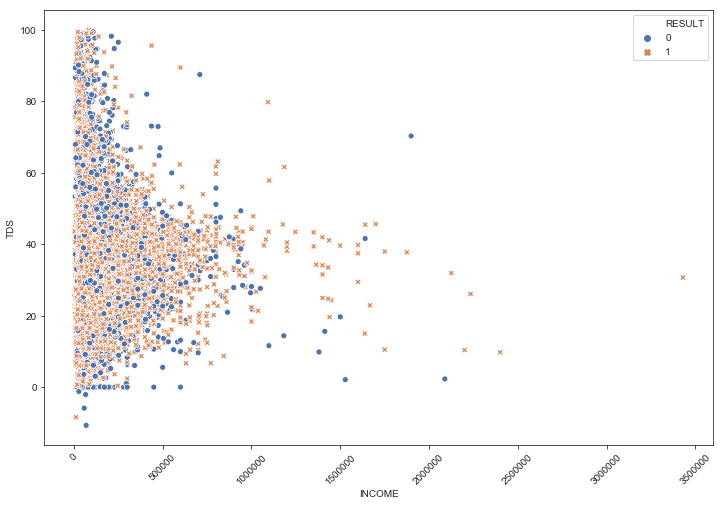

In [439]:
scatter_plot('INCOME', 'TDS', 'RESULT', df)

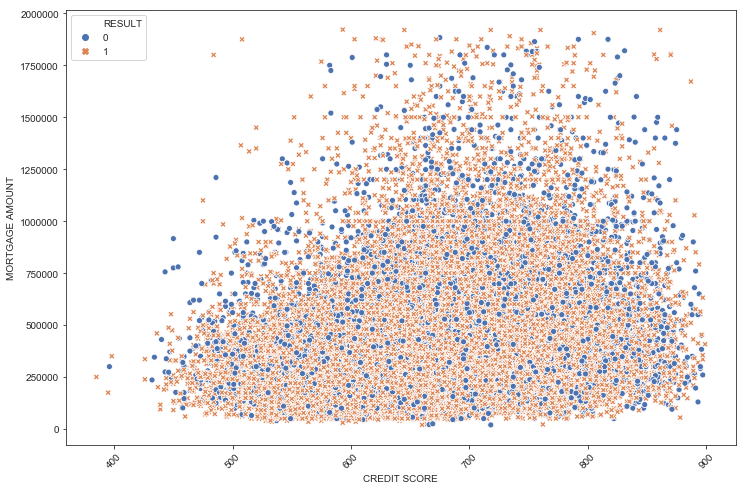

In [440]:
scatter_plot('CREDIT SCORE', 'MORTGAGE AMOUNT', 'RESULT', df[df['CREDIT SCORE'] > 0])

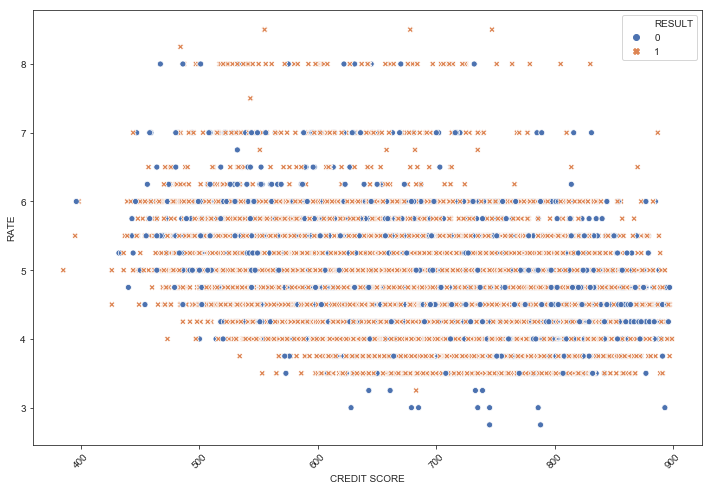

In [441]:
scatter_plot('CREDIT SCORE', 'RATE', 'RESULT', df[df['CREDIT SCORE'] > 0])

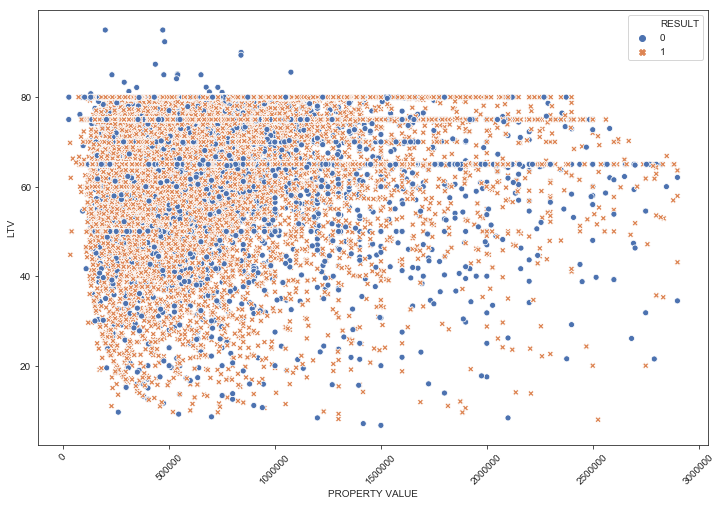

In [442]:
scatter_plot('PROPERTY VALUE', 'LTV', 'RESULT', df)

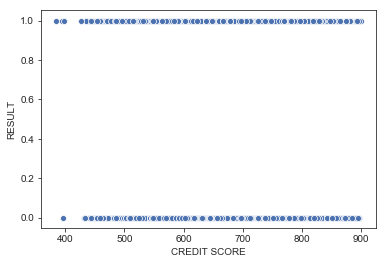

In [443]:
plt.figure(figsize=(6,4))
data = df
x1 = df[df['CREDIT SCORE'] > 0]['CREDIT SCORE']
y1 = df[df['CREDIT SCORE'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

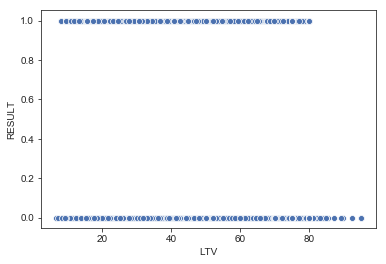

In [444]:
plt.figure(figsize=(6,4))
data = df
x1 = df[df['LTV'] > 0]['LTV']
y1 = df[df['LTV'] > 0]['RESULT']

ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

In [445]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'PROPERTY_VAL_DELTA', 'TERRITORY', 'URBAN'],
      dtype='object')

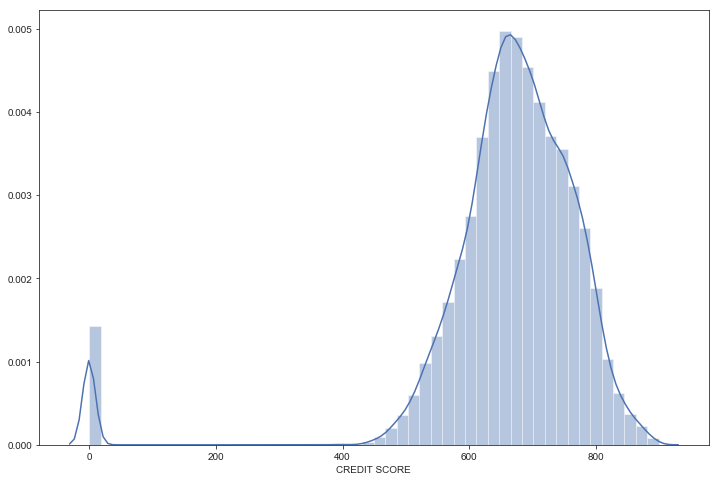

In [446]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

## ENCODING & FEATURE ENGINEERING

In [447]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'PROPERTY_VAL_DELTA', 'TERRITORY', 'URBAN'],
      dtype='object')

In [448]:
# Before Removing Low Value Counts
len(df)

44944

In [449]:
columns_to_check = ['TERRITORY', 'INCOME TYPE', 'RATE', 'AMORTIZATION']
thresh = 5

def remove_low_value_counts(df):
    
    for c in columns_to_check:
        
        df = df[df.groupby(c)[c].transform('size') > thresh]
        
    return df

df = remove_low_value_counts(df)

In [450]:
# After Removing Low Value Counts
print(f'Total Observations: {len(df)}')

Total Observations: 44921


In [451]:
drop_first = False

def encode(df):
    
    le = LabelEncoder()
    
    # Encode Age Range
    df['AGE RANGE'] = le.fit_transform(df['AGE RANGE'])
    df['AGE RANGE'] = df['AGE RANGE'].apply(lambda x: x + 1)
    df['AGE RANGE'] = df['AGE RANGE'].replace({11:0})
    
    #Encode Mortgage Purpose
    df['MORTGAGE PURPOSE'] = le.fit_transform(df['MORTGAGE PURPOSE'])
    
    #Encode Payment Frequency based on Monthly or Not
    df['PAYMENT FREQUENCY'] = np.where(df['PAYMENT FREQUENCY'] == 'Monthly', 1, 0)
    
    #Encode Gender
    df['GENDER'] = le.fit_transform(df['GENDER'])
    
    #Encode Term
    df['TERM'] = le.fit_transform(df['TERM'])
    
    #Territory - Drop W & X and Add Dummy Variables
    df_temp = pd.get_dummies(df['TERRITORY'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df = df.drop(['TERRITORY'], axis=1)
    
    #Encode NAICS based on whether 55 or Not
    df['NAICS CODE'] = np.where(df['NAICS CODE'] == '55', 1, 0)
    
    #Property Type Dummy Variables
    df_temp = pd.get_dummies(df['PROPERTY TYPE'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df = df.drop(['PROPERTY TYPE'], axis=1)
    
    #Encode Income Type
    df['INCOME TYPE'] = le.fit_transform(df['INCOME TYPE'])
    
    #Encode Amortization
    df['AMORTIZATION'] = le.fit_transform(df['AMORTIZATION'])
    
    return df

df = encode(df)

In [453]:
df['AGE RANGE'].unique().sum()

55

In [ ]:
df.columns

In [308]:
def add_features(df):
    
    df['ZERO SCORE'] = np.where(df['CREDIT SCORE'] == 0, 1, 0)
    df['GDS_ZERO'] = np.where(df['GDS'] == 0, 1, 0)
    df['TDS_ZERO'] = np.where(df['TDS'] == 0, 1, 0)
    
    df['LOW RATE'] = np.where(df['RATE'] < 3.75, 1, 0)
    df['HIGH RATE'] = np.where(df['RATE'] > 7, 1, 0)
    
    df['LOW TDS'] = np.where(df['TDS'] < 30, 1, 0)
    df['LOW GDS'] = np.where(df['GDS'] < 30, 1, 0)
    
    df['PMT_INCOME_RATIO'] = df['MORTGAGE PAYMENT'] / (df['INCOME'] / 12)
    
    df['LOW_PMT_INCOME_RATIO'] = np.where(df['PMT_INCOME_RATIO'] < 0.20, 1, 0)
    df['HIGH_PMT_INCOME_RATIO'] = np.where(df['PMT_INCOME_RATIO'] > 0.60, 1, 0)
    
    df['HIGH LTV'] = np.where(df['LTV'] > 80, 1, 0)
    df['LTV_70'] = np.where((df['LTV'] > 70) & (df['LTV'] <= 80), 1, 0)
    df['LTV_60'] = np.where((df['LTV'] > 60) & (df['LTV'] <= 70), 1, 0)
    df['LOW LTV'] = np.where(df['LTV'] < 60, 0, 1)
    
    df['MORTGAGE CONSTANT'] = ((df['MORTGAGE PAYMENT'] * 12) / df['MORTGAGE AMOUNT']) * 100
    df = df.drop(['MORTGAGE PAYMENT',  'MORTGAGE AMOUNT'], axis=1)
    
    
    df['LOW MORTGAGE CONSTANT'] = np.where(df['MORTGAGE CONSTANT'] < 5, 1, 0)
    df['HIGH MORTGAGE CONSTANT'] = np.where(df['MORTGAGE CONSTANT'] > 10, 1, 0)
                             
    return df

df = add_features(df)

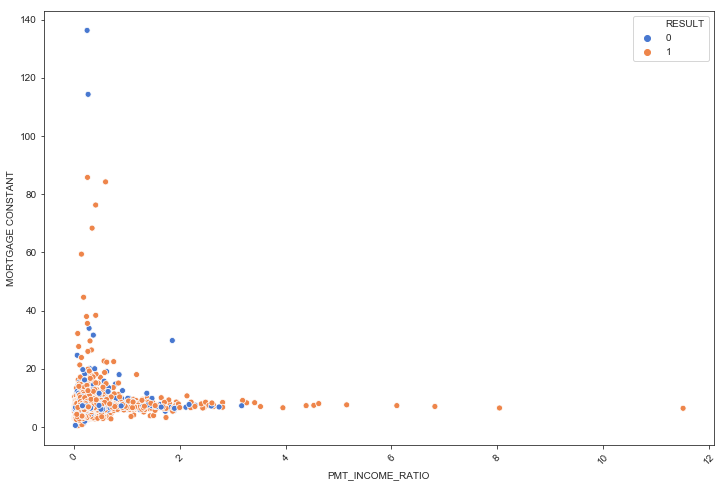

In [309]:
scatter_plot('PMT_INCOME_RATIO', 'MORTGAGE CONSTANT', 'RESULT', df)

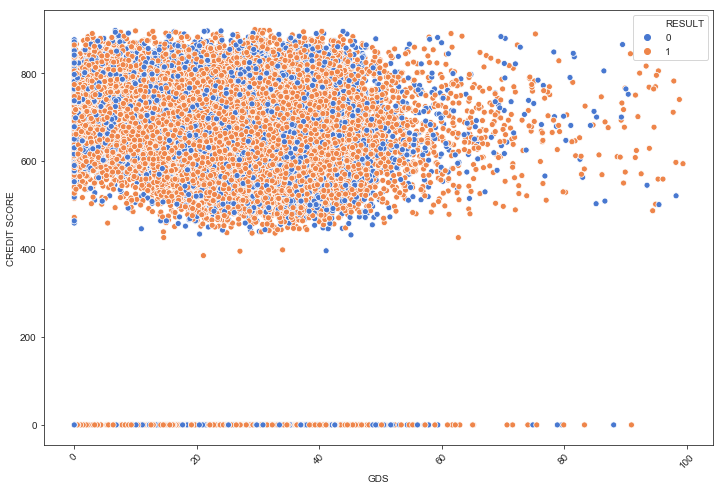

In [310]:
scatter_plot('GDS', 'CREDIT SCORE', 'RESULT', df)

In [311]:
def remove_outliers_2(df):
    
    df = df[df['PMT_INCOME_RATIO'] < 2]
    df = df[df['MORTGAGE CONSTANT'] < 15]
    
    return df

df = remove_outliers_2(df)
df['RESULT'].value_counts()
print(f'Total Observations: {len(df)}')

1    35447
0     9376
Name: RESULT, dtype: int64

Total Observations: 44823


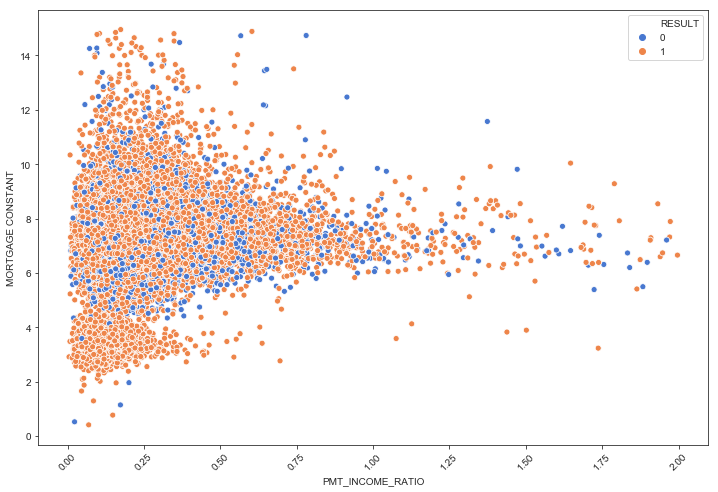

In [312]:
scatter_plot('PMT_INCOME_RATIO', 'MORTGAGE CONSTANT', 'RESULT', df)

In [315]:
def add_natural_logs(df):
    
    cols_to_log = ['PROPERTY VALUE', 'INCOME']
    
    for col in cols_to_log:
        
        df[col] = np.log(df[col])
        
    return df

df = add_natural_logs(df)

In [316]:
apply_interactions = True

def add_interactions(df):
    
    if apply_interactions:
        
        #Interactions with 'Rate'
        df['RATE_X_CREDIT_SCORE'] = df['RATE'] * df['CREDIT SCORE']
        df['RATE_X_LTV'] = df['RATE'] * df['LTV']
        df['RATE_X_PROPERTY_VAL'] = df['RATE'] * df['PROPERTY VALUE']
        df['RATE_X_PROPERTY_VAL_DELTA'] = df['RATE'] * df['PROPERTY_VAL_DELTA']
        df['RATE_X_PMT_INCOME_RATIO'] = df['RATE'] * df['PMT_INCOME_RATIO']
    
        # LTV & Credit Score Interactions
        df['LTV_X_CREDIT'] = df['LTV'] * df['CREDIT SCORE']
        df['CREDIT_X_INCOME'] = df['CREDIT SCORE'] * df['INCOME']
        df['TDS_X_CREDIT'] = df['TDS'] * df['CREDIT SCORE']
        df['TDS_X_INCOME'] = df['TDS'] * df['INCOME']
        df['TDS_X_CONSTANT'] = df['TDS'] * df['MORTGAGE CONSTANT']
        df['TDS_X_PROPERTY_VAL'] = df['TDS'] * df['PROPERTY VALUE']
        df['CREDIT_X_PMT_INCOME_RATIO'] = df['CREDIT SCORE'] * df['PMT_INCOME_RATIO']
    
        #Property Value Delta Interactions
        df['VAL_DELTA_X_LTV'] = df['PROPERTY_VAL_DELTA'] * df['LTV']
        df['INCOME_RATIO_X_PROPERTY_VAL_DELTA'] = df['PMT_INCOME_RATIO'] * df['PROPERTY_VAL_DELTA']
    
        return df
    
    else:
        
        return df

df = add_interactions(df)

In [317]:
apply_poly = False

def add_polynomials(df):
    
    if apply_poly:
        
        cols_to_poly = ['GDS', 'TDS', 'LTV', 'PROPERTY VALUE', 'PROPERTY_VAL_DELTA', 'INCOME_RATIO', 'CREDIT SCORE', 'AMORTIZATION']

        for col in cols_to_poly:

            df[col+'_2'] = df[col] ** 2
            df[col+'_3'] = df[col] ** 3

        return df
    
    else:
        
        return df

df = add_polynomials(df)

In [318]:
len(df.columns)

73

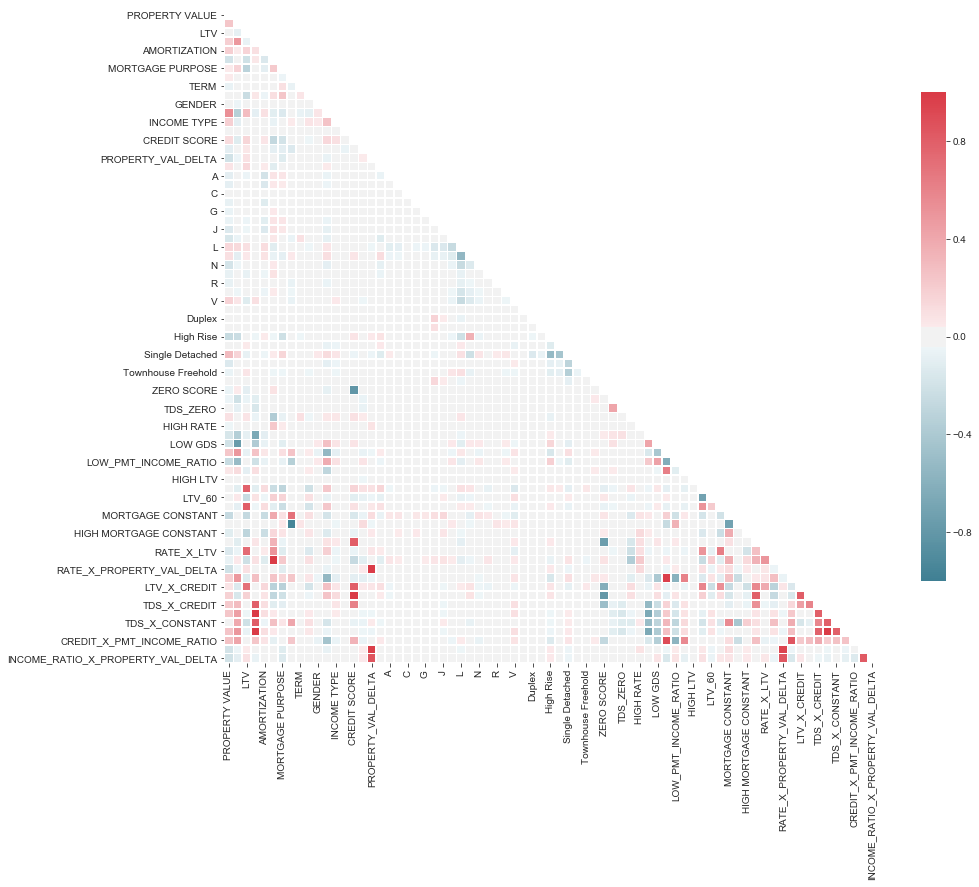

In [319]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [320]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import PolynomialFeatures

## BASELINE DUMMY CLASSIFIER

In [ ]:
def dummy_classifier(df):
    
    y = df['RESULT']
    X = df.drop(['RESULT'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    dummy_classifier = DummyClassifier(strategy="most_frequent")
    dummy_classifier.fit( X,y )
    
    print('Dummy Accuracy score: ', accuracy_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Precision score: ', precision_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Recall score: ', recall_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy AUC score: ', roc_auc_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy F1 score: ', f1_score(y_test, dummy_classifier.predict(X_test)))
        
dummy_classifier(df)

## Test / Train / Split  & Scale

In [352]:
def prepare_data(df):
    
    #Separate Target & Feature
    y = df['RESULT']
    features = df.drop(['RESULT'], axis=1)
    
    #Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=17, test_size=0.20)
    
    #Scale Data
    scaler = StandardScaler()
    X_scaler = scaler.fit(X_train)
    X_train = pd.DataFrame(data = X_scaler.transform(X_train), columns=features.columns)
    X_test = pd.DataFrame(data = X_scaler.transform(X_test), columns=features.columns)

    return X_train, X_test, y_train, y_test, y, features, X_scaler

X_train, X_test, y_train, y_test, y, features, X_scaler = prepare_data(df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


## BASELINE LOGISTIC REGRESSION

## No Adjustment for Imbalance

In [353]:
# Build Logistic Regression Function for training LogReg model
def logreg_model(X_train, y_train):

    lr = LogisticRegression(solver='liblinear', penalty='l1', C=166)
    logreg_clf = lr.fit(X_train, y_train)

    return logreg_clf

## Build Scoring Function

In [354]:
# Scorer Function that takes in Classifier as an argument with test data
def score_model(clf, X_train, X_test, y_train, y_test):
    
    print('Model Scores for: ', '\n\n','---->', clf, '\n')
    print('Train Accuracy score: ', accuracy_score(y_train, clf.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, clf.predict(X_test)),'\n')
    print('Train F1 score: ', f1_score(y_train, clf.predict(X_train)))
    print('Test F1 score: ', f1_score(y_test, clf.predict(X_test)), '\n')
    print("Testing Precision Score: ", precision_score(y_test, clf.predict(X_test)))
    print("Testing Recall Score: ", recall_score(y_test, clf.predict(X_test)))
    print('Test AUC score: ', roc_auc_score(y_test, clf.predict(X_test)))
    
    return clf

logreg_clf = score_model(logreg_model(X_train, y_train), X_train, X_test, y_train, y_test)

Model Scores for:  

 ----> LogisticRegression(C=166, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False) 

Train Accuracy score:  0.7965307602208712
Test Accuracy score:  0.792526491912995 

Train F1 score:  0.8845240733120192
Test F1 score:  0.8821890043070687 

Testing Precision Score:  0.799173743401423
Testing Recall Score:  0.9844500989539158
Test AUC score:  0.5295069109259267


In [355]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (logreg_clf.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (logreg_clf.predict(X_test) == 0).sum())

Target Funded:  7074
Target Not Funded:  1891
Modeled Funded:  8714
Modeled Not Funded:  251


## Build Confusion Matrix Function

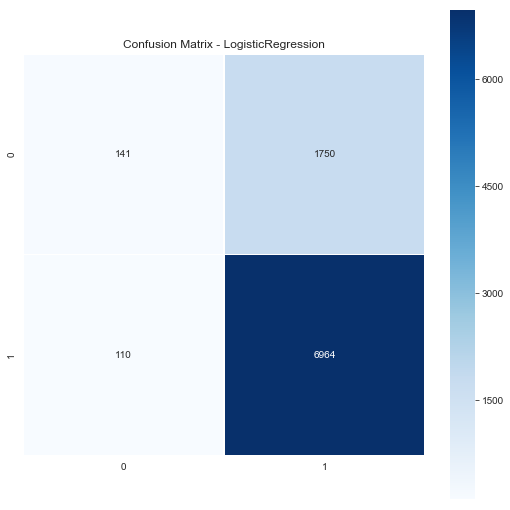

In [356]:
# Confusion Matrix Function that takes in y_test and prediction from scoring function output
def confusion_func(clf, X_test, y_test):
    
    sns.set_style('whitegrid')
    plt.figure(figsize = (9, 9))
    plt.title(f'Confusion Matrix - {clf.__class__.__name__}')
    
    cm_lr = confusion_matrix(y_test, clf.predict(X_test))
    
    return sns.heatmap(cm_lr, annot = True, fmt = 'g', linewidths = .5, square = True, cmap = "Blues")
    
confusion_func(logreg_clf, X_test, y_test);


## Build ROC Curve Function

AUC:  0.703887153812675


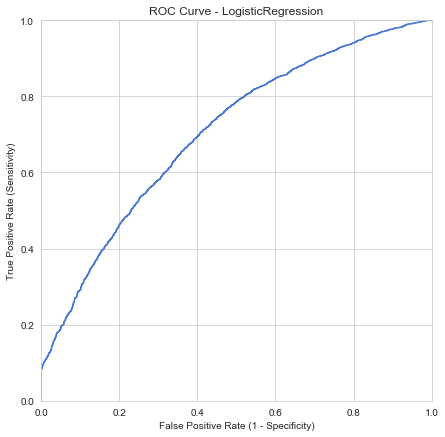

In [357]:
# ROC Function that takes in y_test and prediction from scoring function output
def ROC_func(clf, X_test, y_test):
    
    y_pred_prob = clf.predict_proba(X_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(f'ROC Curve - {clf.__class__.__name__}')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)

    print('AUC: ', roc_auc_score(y_test, y_pred_prob));

ROC_func(logreg_clf, X_test, y_test)

In [358]:
model_params = list(zip(df.columns, logreg_clf.coef_[0]))

model_params.sort(key = lambda x: abs(x[1]), reverse=True)
model_params;

## RandomOverSample

In [359]:
def oversample_random(X_train, y_train):
    
    ros = RandomOverSampler(random_state=1)
    X_res, y_res = ros.fit_sample(X_train, y_train)
    
    X_res = pd.DataFrame(X_res, columns=X_train.columns)
    
    print(f'Before ROS: {Counter(y_train)}')
    print(f'After ROS: {Counter(y_res)}')
    
    return X_res, y_res

In [360]:
# Oversample Data - ROS
X_train_ros, y_train_ros = oversample_random(X_train, y_train)

Before ROS: Counter({1: 28373, 0: 7485})
After ROS: Counter({1: 28373, 0: 28373})


In [361]:
# def oversample_ADASYN(X_train, y_train):
    
#     adasyn = ADASYN(random_state=1)
#     X_ada, y_ada = adasyn.fit_sample(X_train, y_train)
    
#     X_ada = pd.DataFrame(X_ada, columns=X_train.columns)
    
#     print(f'Before Ada: {Counter(y_train)}')
#     print(f'After Ada: {Counter(y_ada)}')
    
#     return X_ada, y_ada

In [362]:
# Oversample Data - ADASYN
# X_train_ada, y_train_ada = oversample_ADASYN(X_train, y_train)

# PCA

In [363]:
from sklearn.decomposition import PCA

In [364]:
pca = PCA(n_components=45)
X_train_pca = pca.fit_transform(X_train_ros)
X_test_pca = pca.transform(X_test)

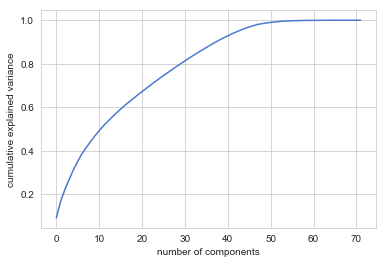

In [365]:
pca_plot = PCA().fit(X_train_ros)
plt.plot(np.cumsum(pca_plot.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

## Logistic Regression (Oversample)

In [366]:
# Train Model - PCA
#logreg_ros_trainer_pca = logreg_model(X_train_pca, y_train_ada)

In [367]:
# Score model - PCA
#logreg_clf_pca = score_model(logreg_ros_trainer_pca, X_train_pca, X_test_pca, y_train_ada, y_test)

In [368]:
# Train Model - ROS
logreg_ros_trainer = logreg_model(X_train_ros, y_train_ros)

In [369]:
# Score model - ROS
logreg_ros_clf = score_model(logreg_ros_trainer, X_train_ros, X_test, y_train_ros, y_test)

Model Scores for:  

 ----> LogisticRegression(C=166, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False) 

Train Accuracy score:  0.646812110104677
Test Accuracy score:  0.6408254322364751 

Train F1 score:  0.6462635461894172
Test F1 score:  0.736842105263158 

Testing Precision Score:  0.8733049205734211
Testing Recall Score:  0.6372632174158892
Test AUC score:  0.6457072300723021


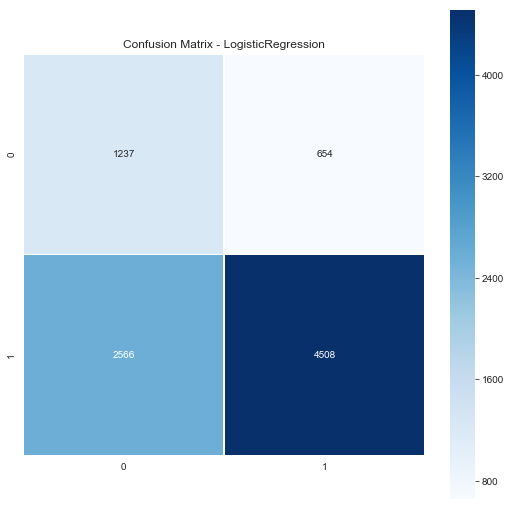

In [370]:
confusion_func(logreg_ros_clf, X_test, y_test);

AUC:  0.7032731117608864


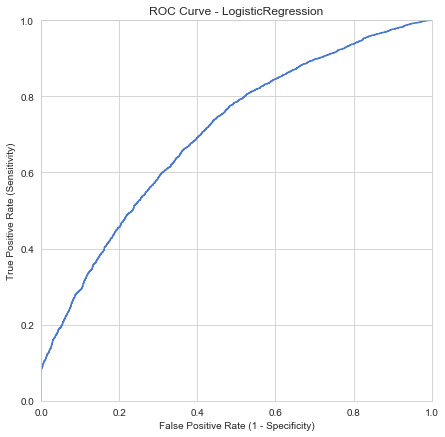

In [371]:
ROC_func(logreg_ros_clf, X_test, y_test)

# Decision Tree

In [372]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_model(X_train, y_train):
    
    criterion = 'entropy'
    max_depth = 40
    min_samples_leaf = 5
    min_impurity_decrease = 0.0005
    
    dt_clf = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, \
                                    min_impurity_decrease=min_impurity_decrease)
    decision_tree_clf = dt_clf.fit(X_train, y_train)
    
    return decision_tree_clf

In [373]:
# Train Model - ROS
decision_tree_ros_trainer = decision_tree_model(X_train_ros, y_train_ros)

In [374]:
# Score model - ROS
decision_tree_clf_ros = score_model(decision_tree_ros_trainer, X_train_ros, X_test, y_train_ros, y_test)

Model Scores for:  

 ----> DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=40,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 

Train Accuracy score:  0.6693158989179854
Test Accuracy score:  0.6522030117122142 

Train F1 score:  0.6708529932819982
Test F1 score:  0.7495179948586118 

Testing Precision Score:  0.8680684778563453
Testing Recall Score:  0.6594571670907549
Test AUC score:  0.6422616348409882


In [375]:
# Train Model - PCA
#decision_tree_pca_trainer = decision_tree_model(X_train_pca, y_train_ada)

In [376]:
# Score model - PCA
#decision_tree_clf_ros = score_model(decision_tree_pca_trainer, X_train_pca, X_test_pca, y_train_ada, y_test)

In [377]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (decision_tree_clf_ros.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (decision_tree_clf_ros.predict(X_test) == 0).sum())

Target Funded:  7074
Target Not Funded:  1891
Modeled Funded:  5374
Modeled Not Funded:  3591


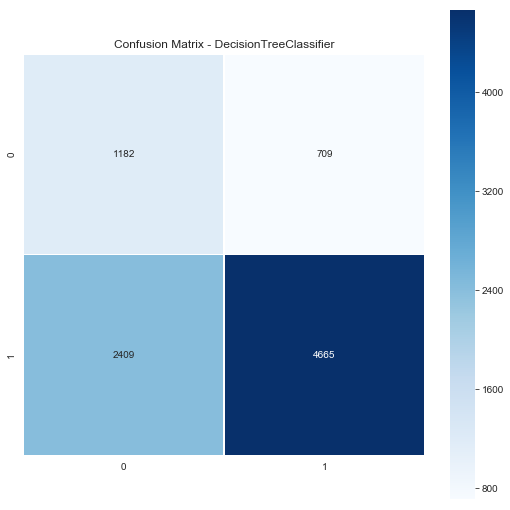

In [378]:
confusion_func(decision_tree_clf_ros, X_test, y_test);

AUC:  0.7048432772412572


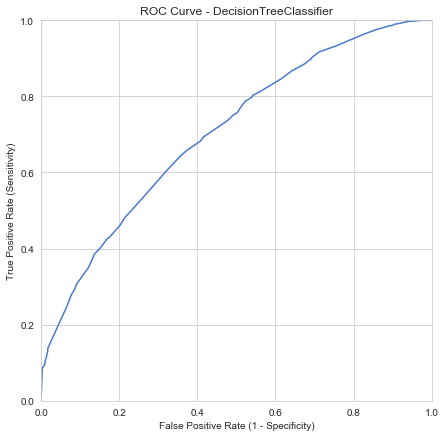

In [379]:
ROC_func(decision_tree_clf_ros, X_test, y_test)

In [380]:
# Build Function to print Feature Importance

def print_feature_importance(clf, X_train, top_n=50):
    
    title = f'Feature Importance - {clf.__class__.__name__}'
    figsize = (10,10)
    
    feat_imp = pd.DataFrame({'importance': clf.feature_importances_})    
    feat_imp['feature'] = X_train.columns
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()

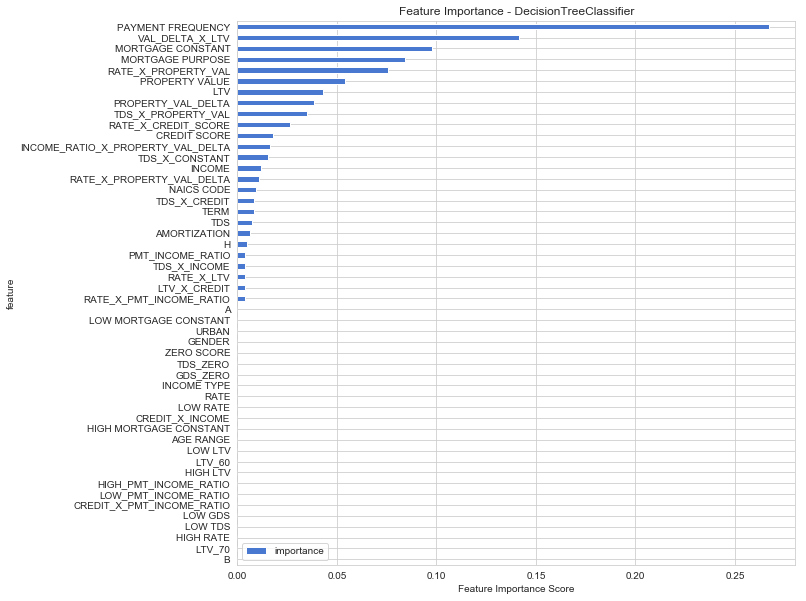

In [381]:
#Feature Importance - ROS
print_feature_importance(decision_tree_clf_ros, X_train)

## Random Forest Classifier

In [382]:
from sklearn.ensemble import RandomForestClassifier

In [383]:
def rfc_model(X_train, y_train):
    
    criterion = 'entropy'
    max_features = 0.15
    n_estimators = 350
    class_weight = 'balanced'
    min_samples_leaf = 5
    
    rfc = RandomForestClassifier(criterion=criterion, max_features=max_features, n_estimators=n_estimators, class_weight=class_weight, \
                                 min_samples_leaf=min_samples_leaf, random_state=1)
    rfc_clf = rfc.fit(X_train, y_train)
    
    return rfc_clf

In [384]:
#Train PCA Model
#rfc_PCA_trainer = rfc_model(X_train_pca, y_train_ada)

In [385]:
# Score model
#rfc_clf_PCA = score_model(rfc_PCA_trainer, X_train_pca, X_test_pca, y_train_ada, y_test)

In [386]:
# Train Model - ROS
rfc_ros_trainer = rfc_model(X_train_ros, y_train_ros)

In [387]:
# Score model - ROS
rfc_clf_ros = score_model(rfc_ros_trainer, X_train_ros, X_test, y_train_ros, y_test)

Model Scores for:  

 ----> RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=0.15,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=350, n_jobs=None, oob_score=False, random_state=1,
            verbose=0, warm_start=False) 

Train Accuracy score:  0.9957353822295845
Test Accuracy score:  0.796207473508087 

Train F1 score:  0.9957350815974056
Test F1 score:  0.8754006683489054 

Testing Precision Score:  0.8456977203847674
Testing Recall Score:  0.9072660446706248
Test AUC score:  0.6440084850534509


In [346]:
# Train Model - Ada
#rfc_ada_trainer = rfc_model(X_train_ada, y_train_ada)

In [347]:
# Score model - Ada
#rfc_clf_ada = score_model(rfc_ada_trainer, X_train_ada, X_test, y_train_ada, y_test)

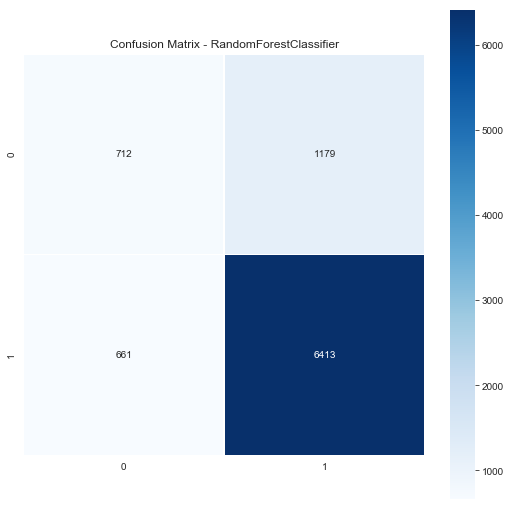

In [348]:
confusion_func(rfc_clf_ros, X_test, y_test);

AUC:  0.7439606116020308


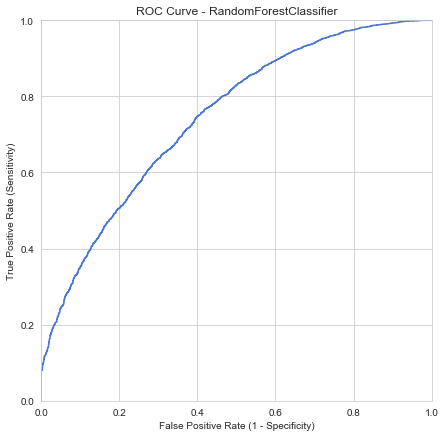

In [349]:
ROC_func(rfc_clf_ros, X_test, y_test)

In [350]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (rfc_clf_ros.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (rfc_clf_ros.predict(X_test) == 0).sum())

Target Funded:  7074
Target Not Funded:  1891
Modeled Funded:  7592
Modeled Not Funded:  1373


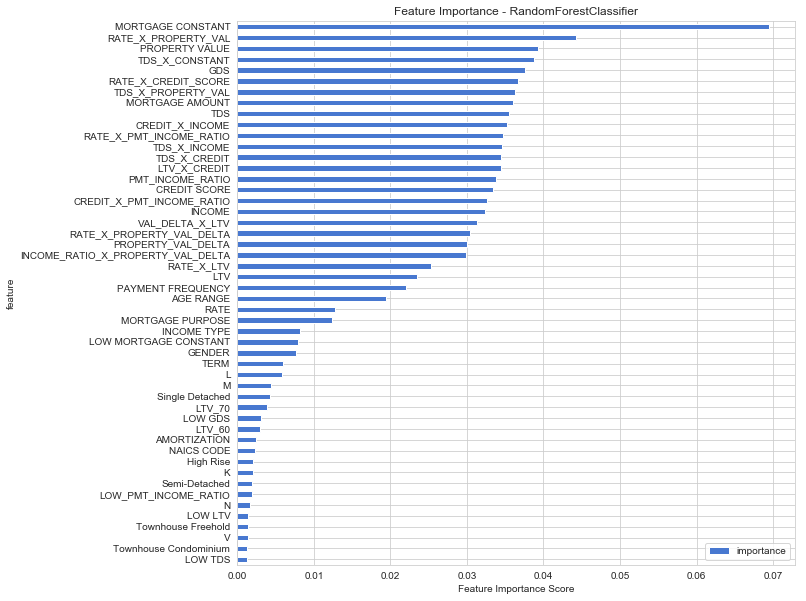

In [351]:
#Feature Importance - RFC
print_feature_importance(rfc_clf_ros, X_train)

## Grid Search - RFC

In [140]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [145]:
rfc_parameters = {
                'max_features': np.arange(0.20, 0.25, 0.30),
                'n_estimators': [300, 350, 400, 450],
                'min_samples_leaf': [5, 7, 10]
                }

xgb_parameters = {
                'max_depth': [35, 40, 45],
                'alpha': [5, 10],
                'n_estimators': [300, 325, 350]
                }

lr_hyperparams = {
                'penalty': ['l1', 'l2'],
                'C': np.logspace(0, 5, 10)
                }


def run_grid_search(clf, params, X_train, y_train):
    
    cv = 5
    n_jobs = -1
    scoring = 'roc_auc'
    
    grid = GridSearchCV(clf, params, cv=cv, n_jobs=n_jobs, scoring=scoring, verbose=5)
    grid = grid.fit(X_train_ros, y_train_ros)
    
    best_grid_clf = grid.best_estimator_
    
    print('Grid Search: ', clf.__class__.__name__, '\n')
    print('Grid Search Best Score: ', grid.best_score_)
    print('Grid Search Best Params: ', grid.best_params_)
    print('Grid Search Best Estimator: ', grid.best_estimator_)

    return best_grid_clf

In [146]:
best_logreg_clf_grid = run_grid_search(LogisticRegression(solver='liblinear'), lr_hyperparams, X_train_ros, y_train_ros)

Grid Search:  LogisticRegression 

Grid Search Best Score:  0.7036126306974312
Grid Search Best Params:  {'C': 1.0, 'penalty': 'l1'}
Grid Search Best Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)


In [3401]:
best_rfc_grid_clf = run_grid_search(RandomForestClassifier(criterion='entropy', class_weight = 'balanced'), rfc_parameters, X_train_ros, y_train_ros)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 37.4min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 79.7min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 449.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 459.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 459.5min finished


Grid Search:  RandomForestClassifier 

Grid Search Best Score:  0.9825609298382298
Grid Search Best Params:  {'max_features': 0.2, 'min_samples_leaf': 5, 'n_estimators': 400}
Grid Search Best Estimator:  RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=0.2,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)


## Randomized Search

In [3402]:
# dt_param_distributions = {
#                   'criterion': ['entropy', 'gini'],
#                   'max_depth': range(5,50, 2), 
#                   'min_samples_leaf': range(1,25, 2),
#                   'min_impurity_decrease': [0.0005, 0.00075],
#                   'min_samples_split': [2, 3]
#                  }
    
# rfc_param_distributions = {
#               'criterion': ['entropy', 'gini'],
#               'n_estimators': [150, 200, 250, 300, 350, ],
#               'max_features': [0.50, 0.625, 0.75],
#              }

# def run_randomized_search(clf, params, X_train, y_train):
    
#     cv = 5
#     scoring = 'f1'

#     randomized_search = RandomizedSearchCV(estimator=clf, cv=cv, param_distributions=params, scoring=scoring, verbose=10)
#     randomized_search = randomized_search.fit(X_train, y_train)

#     best_clf = randomized_search.best_estimator_
    
#     print('Randomized Search: ', clf.__class__.__name__, '\n')
#     print('Randomized Search Best Score: ', randomized_search.best_score_)
#     print('Ranodmized Search Best Params: ', randomized_search.best_params_)
#     print('Randomized Search Best Estimator: ', randomized_search.best_estimator_)

#     return best_clf

In [3403]:
# best_rfc_clf = run_randomized_search(RandomForestClassifier(), rfc_param_distributions, X_train_ros, y_train_ros)

## XGBoost

In [184]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [185]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]= "True"

In [186]:
def xgb_model(X_train, y_train):
    
    objective = 'binary:logistic'
    colsample_bytree = 0.8
    learning_rate = 0.10
    max_depth = 35
    alpha = 5
    n_estimators = 350

    xgb_clf = XGBClassifier(objective=objective, colsample_bytree=colsample_bytree, learning_rate=learning_rate, \
                                max_depth=max_depth, alpha=alpha, n_estimators=n_estimators)
    
    xgb_clf = xgb_clf.fit(X_train, y_train)
    
    return xgb_clf

In [187]:
# Train Model
xgb_trainer_ros = xgb_model(X_train_ros, y_train_ros)

In [188]:
# Score model
X_test = X_test[X_train_ros.columns]
xgb_clf = score_model(xgb_trainer_ros, X_train_ros, X_test, y_train_ros, y_test)

Model Scores for:  

 ----> XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=35, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1) 

Train Accuracy score:  0.999982377612519
Test Accuracy score:  0.8089235917456776 

Train F1 score:  0.9999823773019649
Test F1 score:  0.886473590032474 

Testing Precision Score:  0.8344354335620712
Testing Recall Score:  0.9454339836019225
Test AUC score:  0.6218444375968365


In [ ]:
# Model Scores for:  

#  ----> XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
#        max_depth=40, min_child_weight=1, missing=None, n_estimators=300,
#        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
#        silent=True, subsample=1) 

# Train Accuracy score:  0.999982377612519
# Test Accuracy score:  0.8071388733965421 

# Train F1 score:  0.9999823773019649
# Test F1 score:  0.8853828306264501 

# Testing Precision Score:  0.8336037947821745
# Testing Recall Score:  0.9440203562340967
# Test AUC score:  0.6195511617236058

In [3409]:
best_grid_xgb = run_grid_search(XGBClassifier(objective='binary:logistic', colsample_bytree = 0.8, learning_rate = 0.10), \
                                xgb_parameters, X_train_ros, y_train_ros)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 67.3min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 81.7min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 119.6min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 147.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 183.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 212.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 260.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 299.4min finished


Grid Search:  XGBClassifier 

Grid Search Best Score:  0.99357759458007
Grid Search Best Params:  {'alpha': 5, 'max_depth': 35, 'n_estimators': 350}
Grid Search Best Estimator:  XGBClassifier(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=35, min_child_weight=1, missing=None, n_estimators=350,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


In [189]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (xgb_clf.predict(X_test) == 1).sum())
print('Modeled Not Funded: ', (xgb_clf.predict(X_test) == 0).sum())

Target Funded:  7074
Target Not Funded:  1891
Modeled Funded:  8015
Modeled Not Funded:  950


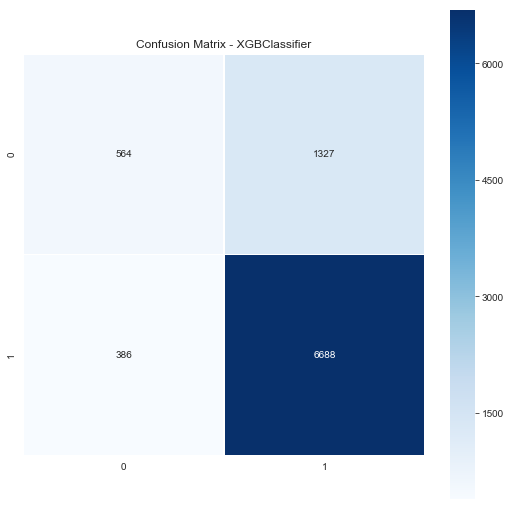

In [190]:
confusion_func(xgb_clf, X_test, y_test);

AUC:  0.7410198031925701


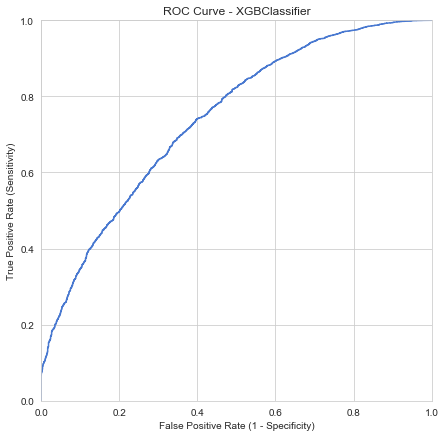

In [191]:
ROC_func(xgb_clf, X_test, y_test)

# Ada Boost

In [179]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)

abc_dt =AdaBoostClassifier(n_estimators=50, base_estimator=decision_tree_clf_ros, learning_rate=1)

In [ ]:
model = abc.fit(X_train_ros, y_train_ros)

In [ ]:
print('Model Scores for: ', '\n\n','---->', model, '\n')
print('Train Accuracy score: ', accuracy_score(y_train_ros, model.predict(X_train_ros)))
print('Test Accuracy score: ', accuracy_score(y_test, model.predict(X_test)),'\n')
print('Train F1 score: ', f1_score(y_train_ros, model.predict(X_train_ros)))
print('Test F1 score: ', f1_score(y_test, model.predict(X_test)), '\n')
print("Testing Precision Score: ", precision_score(y_test, model.predict(X_test)))
print("Testing Recall Score: ", recall_score(y_test, model.predict(X_test)))
print('Test AUC score: ', roc_auc_score(y_test, model.predict(X_test)))

Model Scores for:  

 ----> AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
          n_estimators=50, random_state=None) 

Train Accuracy score:  0.6622845663130441
Test Accuracy score:  0.6534300055772448 

Train F1 score:  0.6655730839033924
Test F1 score:  0.7489292929292929 

Testing Precision Score:  0.8741746840218827
Testing Recall Score:  0.6550749222504948
Test AUC score:  0.6511757477460829


In [180]:
model_dt = abc_dt.fit(X_train_ros, y_train_ros)

In [182]:
print('Model Scores for: ', '\n\n','---->', model_dt, '\n')
print('Train Accuracy score: ', accuracy_score(y_train_ros, model_dt.predict(X_train_ros)))
print('Test Accuracy score: ', accuracy_score(y_test, model_dt.predict(X_test)),'\n')
print('Train F1 score: ', f1_score(y_train_ros, model_dt.predict(X_train_ros)))
print('Test F1 score: ', f1_score(y_test, model_dt.predict(X_test)), '\n')
print("Testing Precision Score: ", precision_score(y_test, model_dt.predict(X_test)))
print("Testing Recall Score: ", recall_score(y_test, model_dt.predict(X_test)))
print('Test AUC score: ', roc_auc_score(y_test, model_dt.predict(X_test)))

Model Scores for:  

 ----> AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=40,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=50, random_state=None) 

Train Accuracy score:  0.6939696190039827
Test Accuracy score:  0.6759620747350809 

Train F1 score:  0.7010912595958553
Test F1 score:  0.7722461779694236 

Testing Precision Score:  0.8669248371765534
Testing Recall Score:  0.6962114786542267
Test AUC score:  0.648211503473068


# Voting Classifier

In [388]:
from sklearn.ensemble import VotingClassifier

clf1 = logreg_ros_clf # Logistic Regression Classifier trained on Random Over Sampled data
clf2 = rfc_clf_ros # Random Forest Classifier trained on ROS data
clf3 = xgb_clf # XGBoost Classifier trained on ROS data
clf4 = model_dt #Adaboost with DT base classifier

voting_clf = VotingClassifier(estimators=[('lr', clf1), ('rfc', clf2), ('xgb', clf3), ('ada_dt', clf4)], voting='soft')
voting_clf = voting_clf.fit(X_train_ros, y_train_ros)

KeyboardInterrupt: 

In [ ]:
#Without Class Weights
print('Model Scores for: ', '\n\n','---->', voting_clf, '\n')
print('Train Accuracy score: ', accuracy_score(y_train_ros, voting_clf.predict(X_train_ros)))
print('Test Accuracy score: ', accuracy_score(y_test, voting_clf.predict(X_test)),'\n')
print('Train F1 score: ', f1_score(y_train_ros, voting_clf.predict(X_train_ros)))
print('Test F1 score: ', f1_score(y_test, voting_clf.predict(X_test)), '\n')
print("Testing Precision Score: ", precision_score(y_test, voting_clf.predict(X_test)))
print("Testing Recall Score: ", recall_score(y_test, voting_clf.predict(X_test)))
print('Test AUC score: ', roc_auc_score(y_test, voting_clf.predict(X_test)))

In [ ]:
confusion_func(voting_clf, X_test, y_test);

AUC:  0.7490341209727132


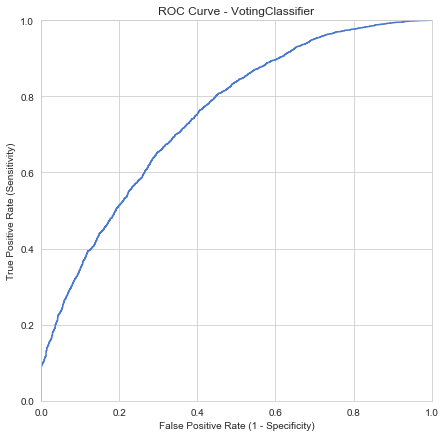

In [195]:
ROC_func(voting_clf, X_test, y_test)

## Run on Test Set for Competition

In [196]:
file = pd.read_csv('CAX_MortgageModeling_Test.csv')
submission = pd.read_csv('CAX_MortgageModeling_SubmissionFormat.csv')

test_df = pd.DataFrame(file)
submission_df = pd.DataFrame(submission)
submission_df.set_index('Unique_ID', inplace=True)

test_df = test_df.drop(['RESULT'], axis=1)

In [197]:
test_df = add_interactions(add_natural_logs(add_features(encode(clean_data(test_df)))))

In [198]:
# Get missing columns in the training test
missing_cols = set( X_train.columns ) - set( test_df.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_df[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_df = test_df[X_train.columns]

In [199]:
test_df = pd.DataFrame(data=X_scaler.transform(test_df), columns=test_df.columns)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [200]:
#test_df = pca.transform(test_df)

In [201]:
# Score model - RFC
print('Modeled Funded: ', (voting_clf.predict(test_df) == 1).sum())
print('Modeled Not Funded: ', (voting_clf.predict(test_df) == 0).sum())

Modeled Funded:  13225
Modeled Not Funded:  1989


In [202]:
rfc_submission = voting_clf.predict(test_df)

In [203]:
submission_df['Result_Predicted'] = rfc_submission

In [204]:
submission_df['Result_Predicted'] = submission_df['Result_Predicted'].replace({1: 'FUNDED', 0: 'NOT FUNDED'})

In [205]:
submission_df['Result_Predicted'].value_counts()

FUNDED        13225
NOT FUNDED     1989
Name: Result_Predicted, dtype: int64

In [206]:
submission_df.to_csv('submission.csv')

In [207]:
submission_df.shape

(15214, 1)